# Análisis comparado de algoritmos de clasificacion: RF, eKDC, fKDC, eRF, fRF
## Intro
Somos fans de la estimación de densidad y se la queremos poner hasta a las tostadas, pero seamos justos: si un algoritmo "de cajita" le pasa el trapo a nuestra admirada metodología... es algo a tener en cuenta. Así que compararemos:
- Random Forest, `RF`
- Kernel Density Classifier (KDC) with Euclidean distance, `eKDC`
- Fermat-distance KDC, `fKDC`

Más tarde, si nos sale:
- `eRF. fRF`: Euclidean/Fermat-ehanced Random 

## Setup
No esperamos, _a priori_, que alguno de estos métodos domine unívocamente a los demás. Luego, quisiéramos comparar su _performance_ en una variedad de escenarios tal que nos permita comprender sus cualidades relativas. A tal fin, intentaremos:
### `X`: El _dataset_
Consideramos primero algunos ejemplos sintéticos en los que imaginamos la distancia en el grafo aproximará mejor la variedad de fondo, con $d$ conocidos (usualmente 1). Luego, probamos suerte en algunos datasets reales bien conocidos: `iris, digits, wine, (mnist)`. (Finalmente, lo soltamos en algo grande, a ver si se puede: CTR? spam? ???)
 - sintéticos (K=2 clases)
    - D=2 dimensiones: lunas, círculos concentricos, rectas perpendiculates (+, X)
    - (D=3: hélice)
  - naturales
    - iris (K=3 clases, D=4 dimensiones)
    - digits (K=10, D=64)
    - wine (K=8, D=??)

Los datasets "naturales" llevan consigo un problema adicional: la estimación de $d$, la dimensión de la variedad _embebida_ en $\mathbb{R}^D$. (Le dedicamos un minuto a esto | Asumimos $D = d$ y vemos qué pasa)

### `train_size`: Las condiciones de evaluación
Siendo `KDC` un método que extrae información de el grafo completo de la muestra $X_n$, sería razonable pensar que en contextos "adversos", cuando los datos de entrenamiento son escasos y el _testeo_ exhaustivo, tener una "buena" noción noción de distancia será más util que en la situación inversa. Decidimos probar tres escenarios a partir de _ratios_ de `train_size` (cf. documentación)
- `adverso`: $\text{train\_size} = p_{adv} (= 0.05)$
- `neutral`:  $\text{train\_size} = p_{neu} = \tfrac{1}{2}$
- `favorable`:  $\text{train\_size} = 1 - p_{adv} (= 0.95)$

### `rs`: El _estado aleatorio_ (`RandomState`) y la venerada reproducibilidad
> _A mayor $n$, menor varianza._ (Anónimo)

Como no confío en ninguno de estos experimentos, los hago todos por cuadruplicado. Idealmente, por $m\text{-uplicado}, n \rightarrow \infty$, pero el cómputo es lento y el número de escenarios, un producto cartesiano ambicioso. Optamos por el literal $m = 4$, _por ahora_.

Hay infinitas maneras de fijar el estado aleatorio de un experimento (lectora/lectoro: siéntase invitado a leer el código para comprender éste al dedillo). Aquí, en la `m`-ésima repetición del evento, inicializamos un estado aleatorio con la semilla $\text{seed} \in \left[m\right] = \{0, 1, \dots, m\}$, y se lo pasamos secuencialmente a las siguientes tareas:
- el llamado a `train_test_split` para definir las condiciones de evaluación
- (el fiteo de los métodos de estimación)
- (???)

### `classifier`: Los métodos de clasificación
Cf. Intro
#### Random Forest
#### (Euclidean) Kernel Density
#### Fermat-distance Kernel Density
<!-- #### Gradient Boosting Trees: LightGBM -->
#### RF/GBT w/distnace features

### `score`(s): Las métricas de evaluación
A cada combinación posible de `dataset, train_size, rs, classifier`, se la evaluará según
- su capacidad predictiva
  - en predicciones "duras" de la clase $\hat{y}_i = j, j\in\left[K\right]$ a la que pertenece la $i$-ésima observación, segúbn su precisión (`accuracy`),
  - (en predicciones "blandas", del vector $a_i \in \mathbb{R}^K$ de probabilidades de pertenencia a las $K$ clases posibles, de alguna manera a determinar)
- sus costos computacionales
  - en tiempo empírico de ejecución
    - en entrenamiento
    - en predicción
  - (en complejidad)




In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits
import networkx as nx
import igraph as ig
import neo4j


In [2]:
# EXPERIMENTAL: Widget support for mpl in notebooks
%matplotlib widget

In [3]:
PI = math.pi

In [4]:
# https://en.wikipedia.org/wiki/Trefoil_knot
def trefoil(n, start=0, noise_dims=47, end=2 * PI):
    T = start + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [
            [
                np.sin(t) + 2 * np.sin(2 * t),  # X
                np.cos(t) - 2 * np.cos(2 * t),  # Y
                -np.sin(3 * t),                 # Z
            ]
            for t in T
        ]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)


In [5]:
X = trefoil(1000, start=0, end=2*PI, noise_dims=0)

In [11]:
X_trefA = trefoil(500)

In [12]:
X_trefB = trefoil(500)

In [13]:
X_trefB[:, [0, 1, 2]] = X_trefB[:, [1, 2, 0]]

In [14]:
X_trefA.shape

(500, 50)

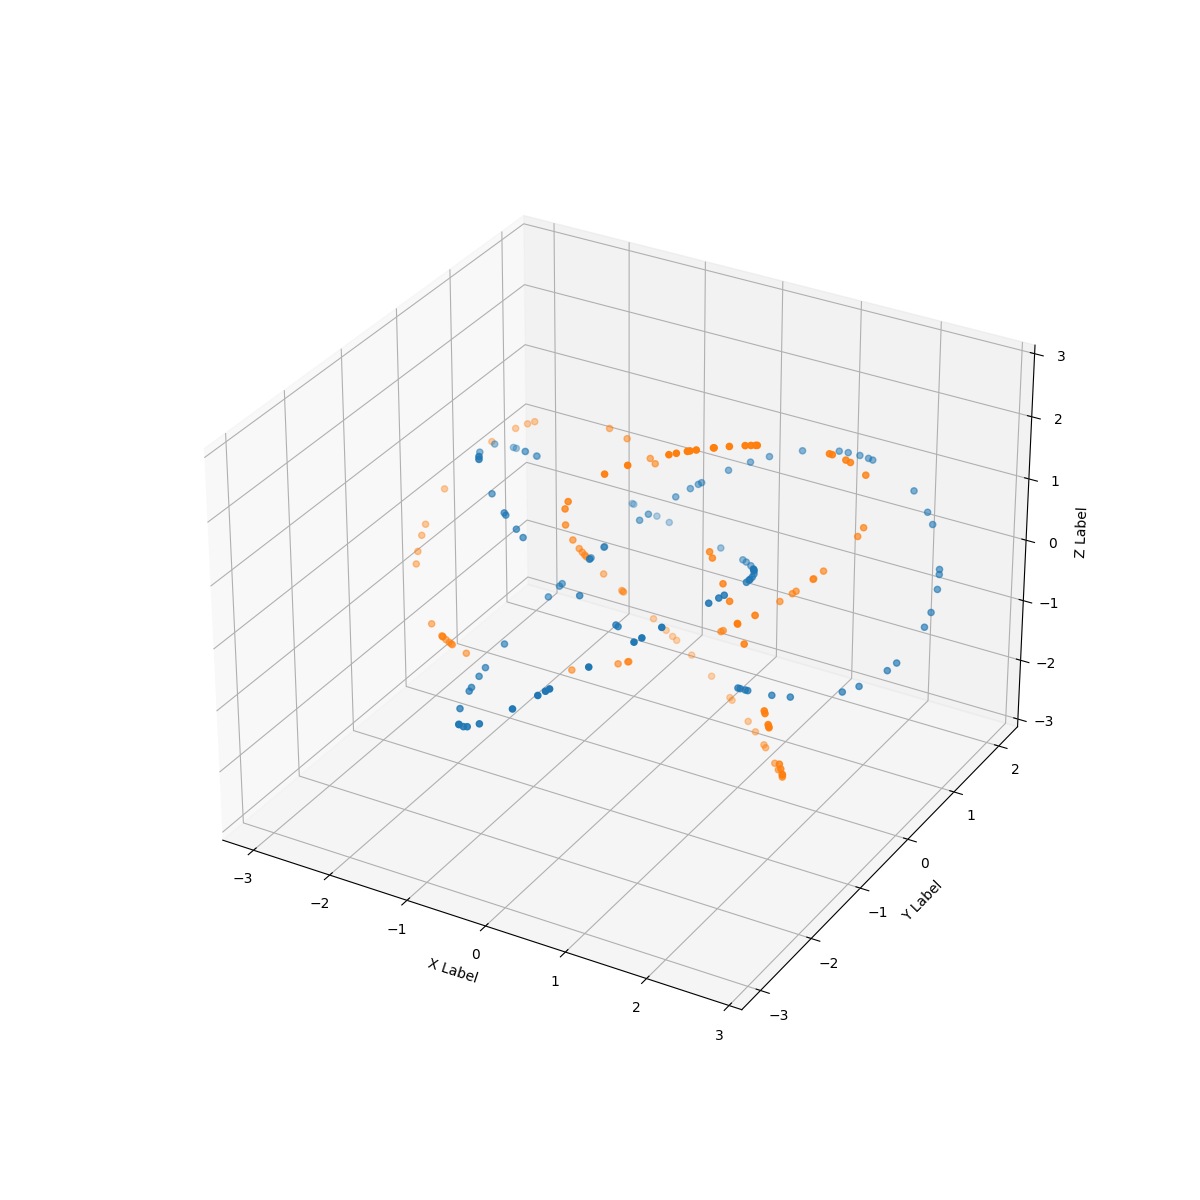

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for i, X in enumerate([X_trefA, X_trefB]):
    ax.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2], color=f"C{i}")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [15]:
from sklearn import datasets
X, y = datasets.make_moons(n_samples=500, noise=0.28)

In [16]:
palette = plt.cm.get_cmap("tab10")

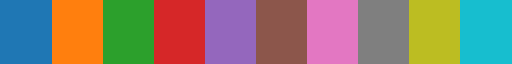

In [17]:
palette

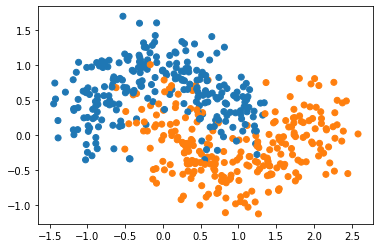

In [13]:
fig = plt.figure()
plt.scatter(x=X[:, 0], y=X[:, 1], color=palette(y))
plt.show()

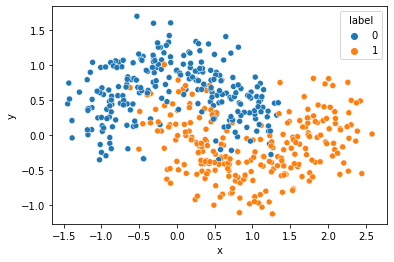

In [14]:
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label": y})
fig = plt.figure()
sns.scatterplot(x="x", y="y", hue="label", data=df)
plt.show()

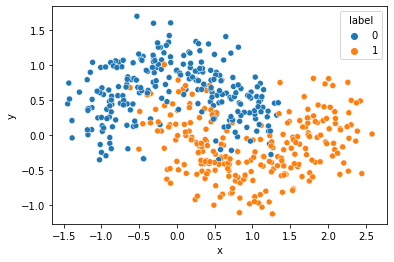

In [15]:
fig = plt.figure()
sns.scatterplot(x="x", y="y", hue="label", data=df)
plt.show()

In [26]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [27]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [28]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [29]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [30]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)

In [22]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


EuclideanKDEClassifier() :  0.845
FermatKDEClassifier(bandwith=20) :  0.89
RandomForestClassifier() :  0.895
RandomForestClassifier()  - enhanced:  0.88


In [23]:
df["eok"] = eucclf.predict(X) == df.label
df["fok"] = fmtclf.predict(X) == df.label
df["rok"] = rfclf.predict(X) == df.label

/home/gonzalo/maestria/fermat/venv/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/gonzalo/maestria/fermat/venv/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/gonzalo/maestria/fermat/venv/lib/python3.8/site-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; 

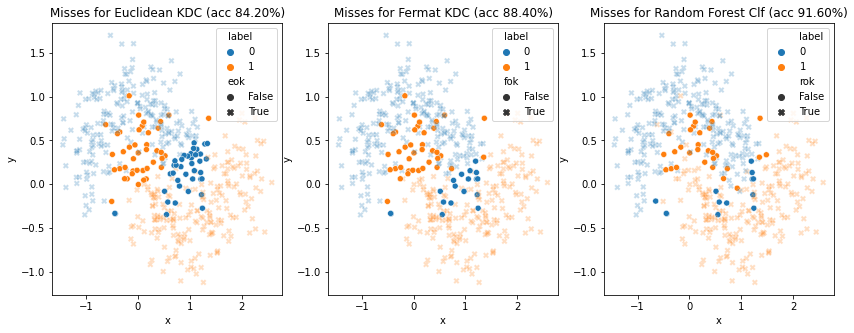

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
ax = axs[0]
sns.scatterplot(x="x", y="y", hue="label", style="eok", alpha=np.where(df.eok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Euclidean KDC (acc {100 * df.eok.mean():.2f}%)")
ax = axs[1]
sns.scatterplot(x="x", y="y", hue="label", style="fok", alpha=np.where(df.fok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Fermat KDC (acc {100 * df.fok.mean():.2f}%)")
ax = axs[2]
sns.scatterplot(x="x", y="y", hue="label", style="rok", alpha=np.where(df.rok, 0.25, 1), data=df, ax=ax)
plt.legend()
ax.set_title(f"Misses for Random Forest Clf (acc {100 * df.rok.mean():.2f}%)")
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV
import time


def get_seed(rng):
    return rng.bit_generator.random_raw() % 2**32


def trial(
    X,
    y,
    test_size,
    stratify,
    seed=None,
    euclid_grid=None,
    fermat_grid=None,
    enhanced=False,
):
    ret = {"locals": locals(), "classifiers": {}}
    rng = np.random.default_rng(seed)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=get_seed(rng),
    )
    ret["locals"]["y_test"] = y_test
    euclid_grid = euclid_grid or dict(bandwith=np.logspace(-2, 1, 5))
    fermat_grid = fermat_grid or dict(
        alpha=[1.25, 1.5, 2], bandwith=np.logspace(-2, 2, 5)
    )
    rf_grid = dict(ccp_alpha=np.logspace(-3, 0, 5))
    classifiers = {
        "rawRF": RandomForestClassifier(),
        "gridRF": GridSearchCV(RandomForestClassifier(), rf_grid),
        "eKDC": GridSearchCV(EuclideanKDEClassifier(), euclid_grid),
        "rawKDC": EuclideanKDEClassifier(),
        "fKDC": GridSearchCV(FermatKDEClassifier(), fermat_grid),
    }
    if enhanced:
        X_train_, X_test_, y_train_, y_test_ = train_test_split(
            X_train,
            y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=get_seed(rng),
        )
        # TODO: write enhanced RF versions
        # cla = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
        # rfclf2 = RandomForestClassifier().fit(
        #     np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
        # )
    for name, clf in classifiers.items():
        try:
            print(name)
            ret["classifiers"][name] = out = {}
            t0 = time.time()
            clf.fit(X_train, y_train)
            out["train_time"] = time.time() - t0
            t0 = time.time()
            out["preds"] = preds = clf.predict(X_test)
            out["test_time"] = time.time() - t0
            out["accuracy"] = accuracy_score(preds, y_test)
        except Exception as exc:
            print(exc)
            continue
    return ret


In [31]:
X_tref = np.vstack([X_trefA, X_trefB])
y_tref = np.hstack([np.zeros(X_trefA.shape[0]), np.ones(X_trefB.shape[0])])
print(X_tref.shape, y_tref.shape)
with np.errstate(divide='ignore'):
    results = trial(X_tref, y_tref, test_size=0.8, stratify=True, seed=None)
df = pd.DataFrame(results["classifiers"]).T
df

(1000, 50) (1000,)
rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.265604,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.035166,0.795
gridRF,5.940629,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.020336,0.80875
eKDC,0.139883,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.044903,0.9725
rawKDC,0.000288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0.048821,0.8275
fKDC,1.434802,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.113339,0.97375


In [ ]:
X, y = datasets.make_moons(n_samples=500, noise=0.14)
with np.errstate(divide='ignore'):
    results = trial(X, y, test_size=0.8, stratify=True, seed=None)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.358998,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.022821,0.975
gridRF,5.86601,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.020557,0.9675
eKDC,0.077084,"[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...",0.004211,0.9925
rawKDC,0.000847,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, ...",0.0062,0.87
fKDC,0.600465,"[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, ...",0.019064,0.9925


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.8)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=20).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)

In [70]:
with np.errstate(divide='ignore'):
    results = trial(*load_digits(return_X_y=True), test_size=0.8, stratify=True, seed=234)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
rawKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.243121,"[0, 0, 9, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.049413,0.926982
gridRF,7.13015,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 2, 1, 0, ...",0.055511,0.905424
eKDC,0.552781,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.235355,0.962448
rawKDC,0.000676,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.333848,0.967316
fKDC,3.6566,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.476597,0.967316


In [30]:
with np.errstate(divide='ignore'):
    results = trial(*load_digits(return_X_y=True), test_size=0.8, stratify=True, seed=234)
df = pd.DataFrame(results["classifiers"]).T
df

rawRF
gridRF
eKDC
fKDC


,train_time,preds,test_time,accuracy
rawRF,0.21212,"[0, 0, 9, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.037638,0.926982
gridRF,8.232387,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.056421,0.929068
eKDC,0.484344,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.247065,0.962448
fKDC,3.962797,"[0, 0, 8, 2, 7, 6, 0, 1, 3, 1, 5, 4, 3, 1, 0, ...",0.569391,0.967316


In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), grid).fit(X_train, y_train)

NameError: name 'grid' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), grid).fit(X_train, y_train)

NameError: name 'grid' is not defined

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X)
clf = SGDClassifier(max_iter=5)
clf.fit(X_features, y)

clf.score(X_features, y)


/home/gonzalo/maestria/fermat/venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1.0

In [ ]:
def segment(n, start=[0, 0], end=[0, 1], noise_dims=48):
    slope = np.array(end) - np.array(start) + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [
            [   
                np.sin(t) + 2 * np.sin(2 * t),  # X
                np.cos(t) - 2 * np.cos(2 * t),  # Y
                -np.sin(3 * t),                 # Z
            ]
            for t in T
        ]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
X_features.shape

(4, 100)